In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
import math
import cv2
import random

In [2]:
opt = {
    'image_size': 256,
    'is_grayscale': True,
    'val_split': 0.75
}

In [3]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_image(img):
    # plt.figure(figsize=(4, 4))
    # img = 1-img
    if opt['is_grayscale']:
        plt.imshow(img , cmap='gray') 
    else:
        plt.imshow(img)
    plt.axis('off')
    # plt.show()

def load_data(dir_path):
    image_list = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            image_list.append(im)
        else:
            continue
    image_list = np.array(image_list)
    print("Dataset shape:",image_list.shape)

    return image_list

In [4]:
# loading the dataset of images
dirpath = 'KIMIA_dataset'
X = load_data(dirpath)

Dataset shape: (99, 256, 256)


In [5]:
# converting the images to binary and inverting them
X = np.round(X)
X_converted = 1-X
# print(X_converted[0][16])

In [6]:
# function to get the vector along which the image is to be aligned
def get_major_axis_vector(img):
    n, m = img.shape
    coordinates = []
    for i in range(n):
        for j in range(m):
            if(img[i][j]):
                coordinates.append([i,j])
    coordinates = np.array(coordinates)
    
    cov = np.cov(coordinates.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    eigenvectors = eigenvectors.T

    indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[indices]

    # print(eigenvalues/np.sum(eigenvalues))
    # print(eigenvectors)
    # the vector along with variance is maximum is the major axis vector
    return eigenvectors[0]

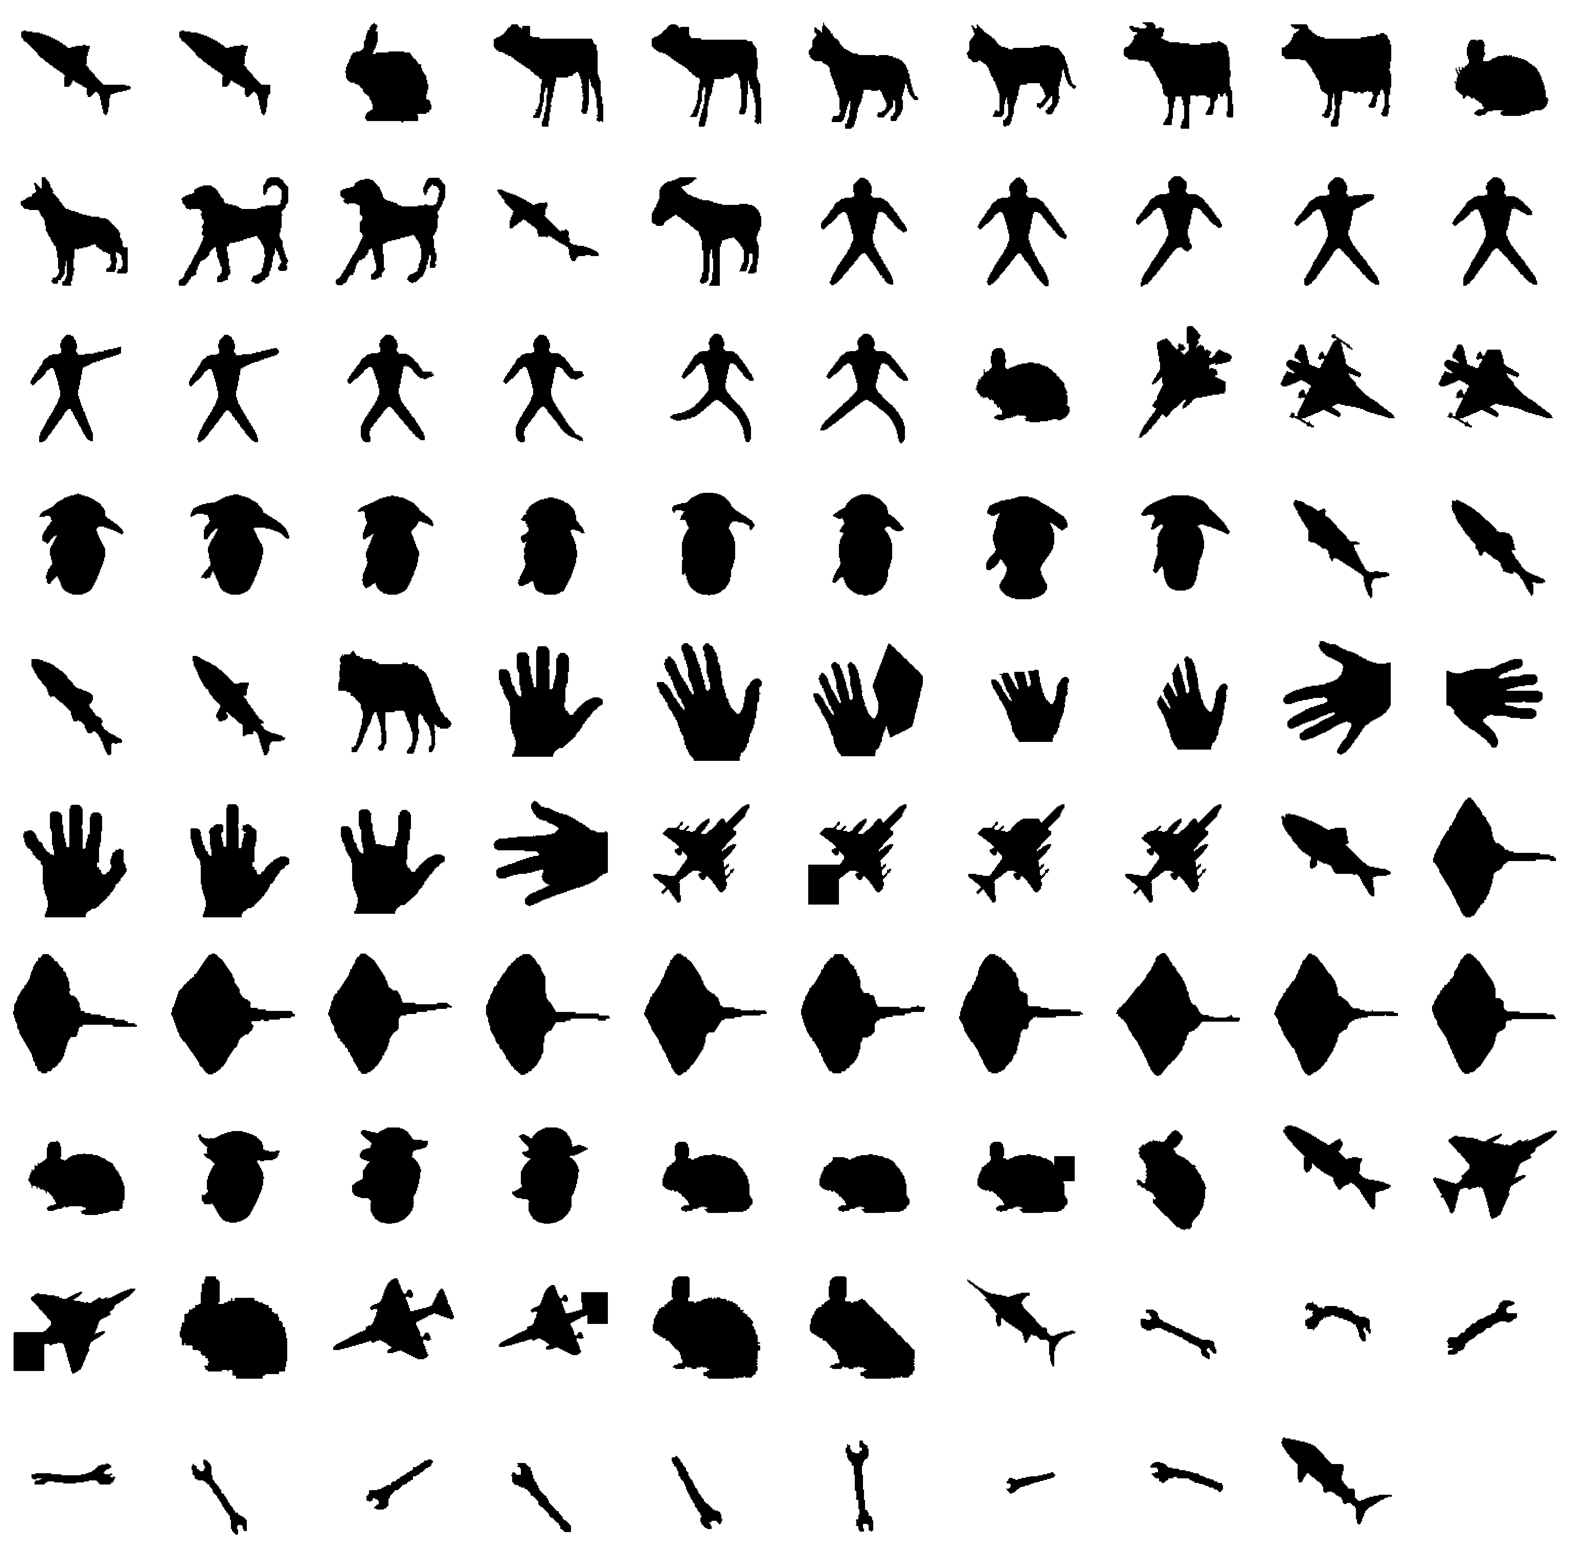

In [8]:
plt.figure(figsize=(20, 20))

i=1
for x in X:
    plt.subplot(10, 10, i)
    # x = 1-x
    display_image(x)
    i = i+1

array([ 0.9308511 , -0.36539873])

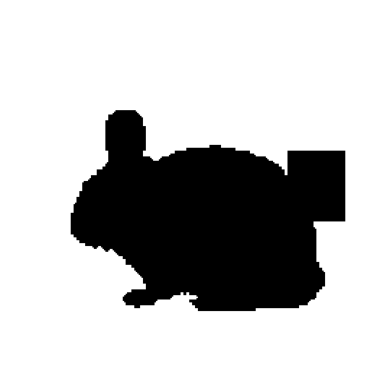

In [9]:
# taking a template image at random
template_idx = random.randint(0, 98)
template_image = X[template_idx]
display_image(template_image)

major_axis_template = get_major_axis_vector(template_image)
major_axis_template

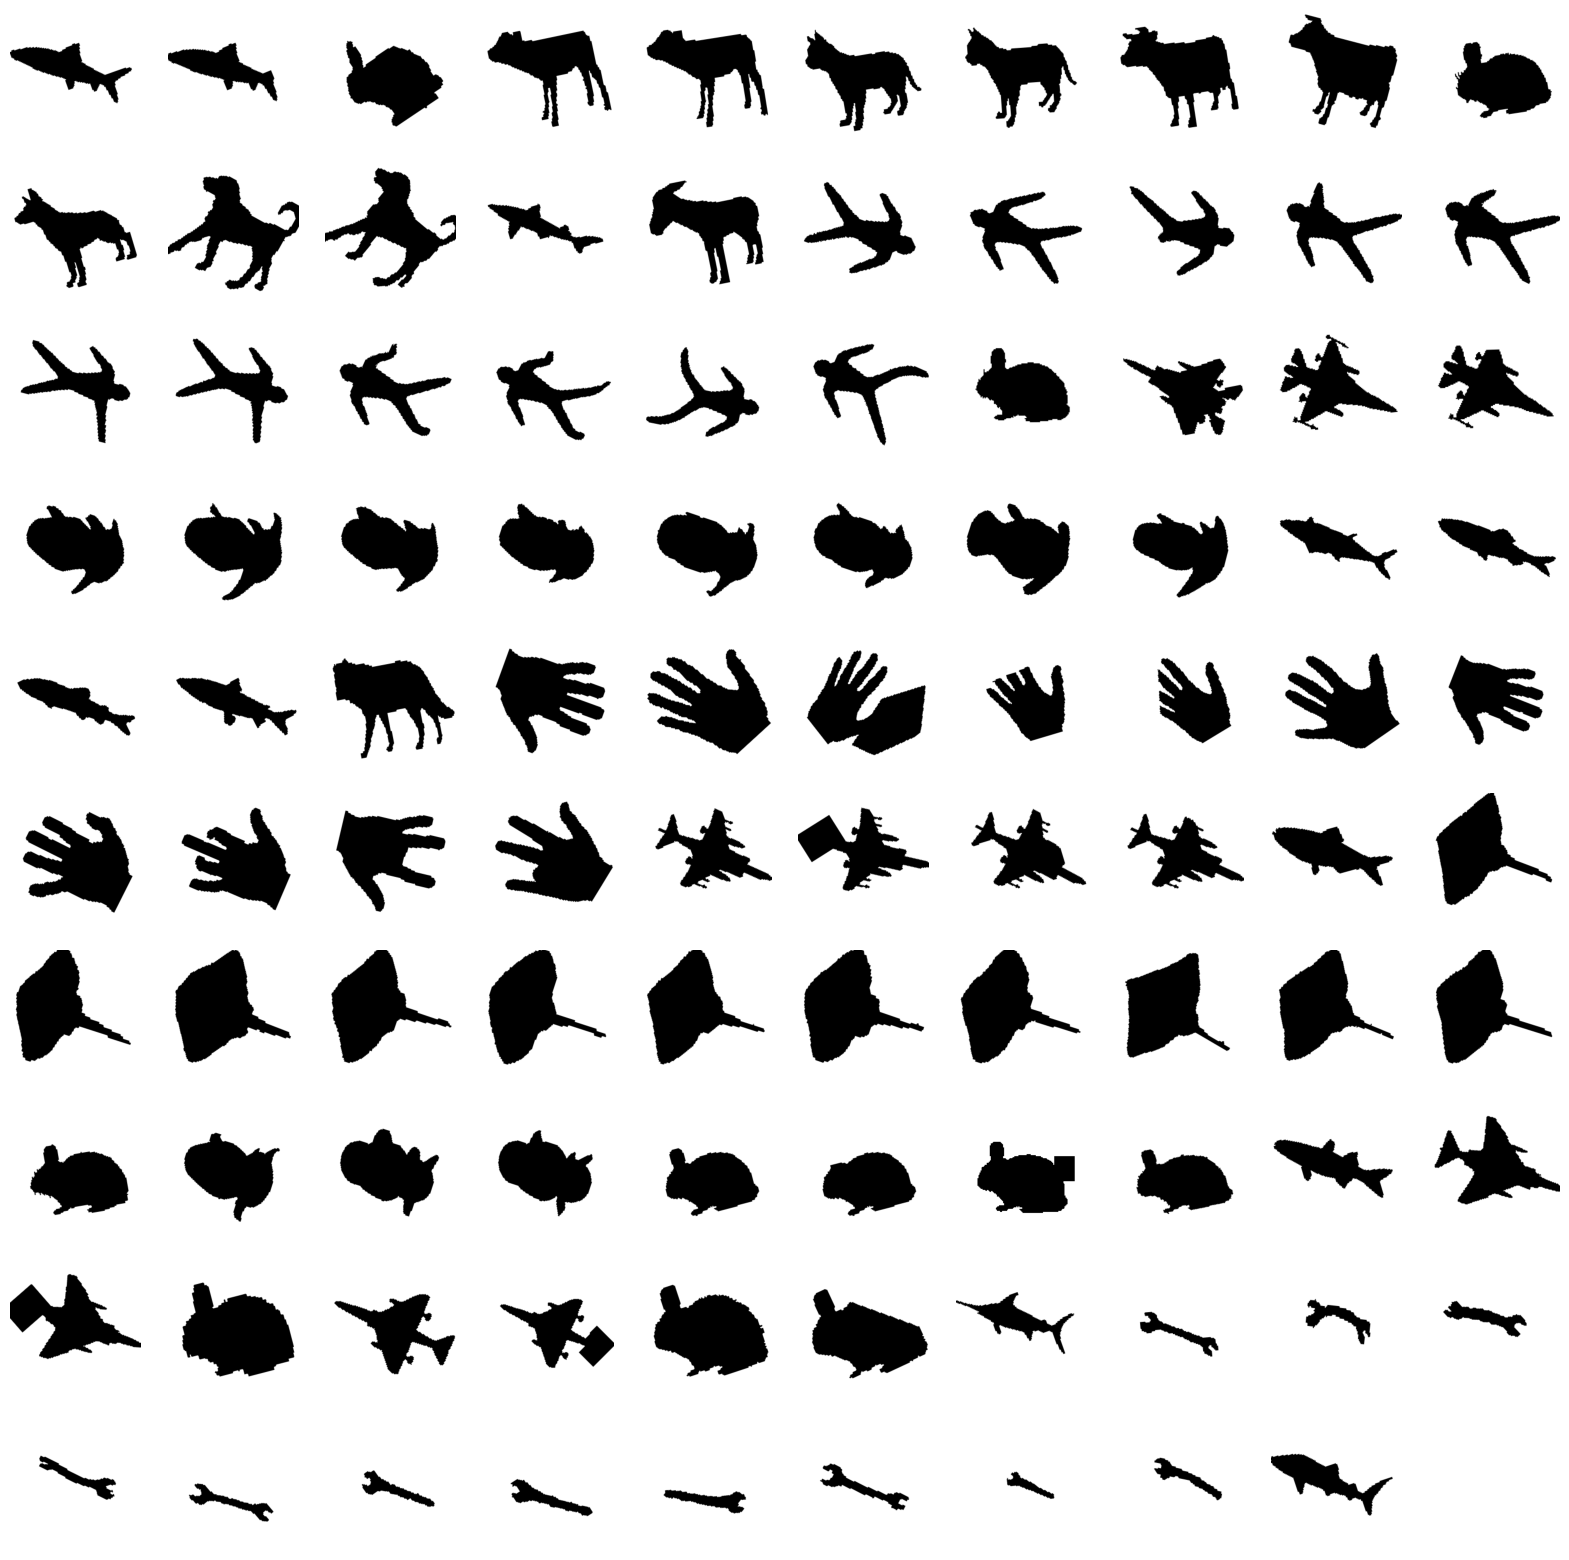

In [10]:
# rotating the images to align them with the template image
plt.figure(figsize=(20, 20))
i = 1

for x in X:
    n, m = x.shape
    major_axis_x = get_major_axis_vector(x)
    
    Ax, Ay = major_axis_template
    Bx, By = major_axis_x

    # finding the slope of the major axis vector for template image
    theta_radians_template = math.atan2(Ay, Ax)
    theta_degrees_template = (math.degrees(theta_radians_template))
    if(theta_degrees_template>90):
        theta_degrees_template = theta_degrees_template-180
    elif(theta_degrees_template<-90):
        theta_degrees_template = theta_degrees_template+180
    # print((theta_degrees_template))

    # finding the slope of the major axis vector for the image to be aligned
    theta_radians_x = math.atan2(By, Bx)
    theta_degrees_x = (math.degrees(theta_radians_x))
    if(theta_degrees_x>90):
        theta_degrees_x = theta_degrees_x-180
    elif(theta_degrees_x<-90):
        theta_degrees_x = theta_degrees_x+180
    # print((theta_degrees_x))

    # difference between the slopes of the major axis vectors and rotating the image accordingly 
    angle_degrees = theta_degrees_template-theta_degrees_x
    rotation_matrix = cv2.getRotationMatrix2D((n / 2, m / 2), angle_degrees, 1)
    rotated_image = cv2.warpAffine(x, rotation_matrix, (n, m), borderValue=1)

    plt.subplot(10, 10, i)
    # rotated_image = 1-rotated_image
    display_image(rotated_image)
    i = i+1
    # break


# Image Processing Workflow

## Step 1: Image Preprocessing

- Loading the images.
- Resizing the images to 256x256 size.
- Converting images into binary format:
  - 1 represents white.
  - 0 represents black.
- Flipping the images so that 1 bit corresponds to foreground and 0 bit corresponds to background

## Step 2: Data Extraction

- Converting binary images into datasets:
  - Extracting coordinate points where the image pixel is 1.
  - This gives us a 2-dataset corresponding to each image

## Step 3: Eigenvalue Calculation

- Calculating the covariance matrix of this 2-dataset for each image
- Calculating the first eigenvector corresponding to the maximum eigenvalue for this covariance matrix.

## Step 4: Template Image

- Choosing a template image at random.

## Step 5: Template Image Angle Calculation

- Finding the angle of the template image with respect to the horizontal axis (the slope of the eigenvector(1st principal component)).

## Step 6: Image Comparison Loop

- For each image:
  - Finding the angle of the image with respect to the horizontal axis.
  - Ensuring angles are in the range of -90 to 90 degrees:
    - If angle > 90, taking the supplementary angle.
    - If angle < -90, taking the supplementary angle.
  - Calculating the angle difference between the template image and the current image.
  - Rotating the current image based on the angle difference.


